In [77]:
#This makes a simple api request to DEVISE for DEM Metrics
import requests

def get_data_from_api():
    url = "https://devise.uwyo.edu/umbraco/api/demapi/GetByExtent"
    
    # Set the query parameters
    params = {
        "xmin": -110,
        "xmax": -109,
        "ymin": 40,
        "ymax": 46,
        "metric": "DEM",
        "scale": "0030m"
    }

    try:
        response = requests.get(url, params=params)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            data = response.json()
            return data
        else:
            print(f"Error: {response.status_code} - {response.text}")
            return None
    except requests.RequestException as e:
        print(f"Error: {e}")
        return None

# Call the function to fetch the data from the API
api_data = get_data_from_api()


print(api_data)


[{'filename': 'Tile_N40_W109_DEM.tif', 'metric': 'DEM', 'scale': '0030m', 'url': 'https://pathfinder.arcc.uwyo.edu/devise/DEM_Metrics/Tile_N40_W109/Tile_N40_W109_DEM.tif'}, {'filename': 'Tile_N40_W110_DEM.tif', 'metric': 'DEM', 'scale': '0030m', 'url': 'https://pathfinder.arcc.uwyo.edu/devise/DEM_Metrics/Tile_N40_W110/Tile_N40_W110_DEM.tif'}, {'filename': 'Tile_N40_W111_DEM.tif', 'metric': 'DEM', 'scale': '0030m', 'url': 'https://pathfinder.arcc.uwyo.edu/devise/DEM_Metrics/Tile_N40_W111/Tile_N40_W111_DEM.tif'}, {'filename': 'Tile_N41_W109_DEM.tif', 'metric': 'DEM', 'scale': '0030m', 'url': 'https://pathfinder.arcc.uwyo.edu/devise/DEM_Metrics/Tile_N41_W109/Tile_N41_W109_DEM.tif'}, {'filename': 'Tile_N41_W110_DEM.tif', 'metric': 'DEM', 'scale': '0030m', 'url': 'https://pathfinder.arcc.uwyo.edu/devise/DEM_Metrics/Tile_N41_W110/Tile_N41_W110_DEM.tif'}, {'filename': 'Tile_N42_W109_DEM.tif', 'metric': 'DEM', 'scale': '0030m', 'url': 'https://pathfinder.arcc.uwyo.edu/devise/DEM_Metrics/Tile_N

In [18]:
#ITerate through sections of the graticule. Was having issues when pulling data for a large bounding box

import requests
import time

def get_data_from_api(params):
    url = "https://devise.uwyo.edu/umbraco/api/demapi/GetByExtent"

    try:
        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            return data
        else:
            print(f"Error: {response.status_code} - {response.text}")
            return None
    except requests.RequestException as e:
        print(f"Error: {e}")
        return None

# Define the initial and final bounding parameters
initial_xmin, final_xmin = -114, -102
initial_xmax, final_xmax = -113, -101
ymin, ymax = 40, 46

# Define the scale and metric
scale = "1530m"
metric = "tri"

# Initialize the master list to store all URLs
master_url_list = []

xmin = initial_xmin
xmax = initial_xmax

while xmin <= final_xmin and xmax <= final_xmax:
    params = {
        "xmin": xmin,
        "xmax": xmax,
        "ymin": ymin,
        "ymax": ymax,
        "metric": metric,
        "scale": scale
    }

    print(f"Fetching data for xmin: {xmin}, xmax: {xmax}")

    # Call the function to fetch the data from the API
    api_data = get_data_from_api(params)

    if api_data is not None:
        # Extract the URLs from the current API response and append to the master list
        url_list = [item['url'] for item in api_data]
        master_url_list.extend(url_list)
        print(f"URLs fetched for xmin: {xmin}, xmax: {xmax}: {len(url_list)}")

    # Increment the x values for the next iteration
    xmin += 1
    xmax += 1

    # Add a short sleep to avoid overwhelming the server with too many requests
    time.sleep(0.5)

print("Master URL List:")
print(master_url_list)
count_items = len(master_url_list)
print("Number of items in the master_url_list:", count_items)


Fetching data for xmin: -114, xmax: -113
URLs fetched for xmin: -114, xmax: -113: 20
Fetching data for xmin: -113, xmax: -112
URLs fetched for xmin: -113, xmax: -112: 17
Fetching data for xmin: -112, xmax: -111
URLs fetched for xmin: -112, xmax: -111: 19
Fetching data for xmin: -111, xmax: -110
URLs fetched for xmin: -111, xmax: -110: 18
Fetching data for xmin: -110, xmax: -109
URLs fetched for xmin: -110, xmax: -109: 20
Fetching data for xmin: -109, xmax: -108
URLs fetched for xmin: -109, xmax: -108: 19
Fetching data for xmin: -108, xmax: -107
URLs fetched for xmin: -108, xmax: -107: 17
Fetching data for xmin: -107, xmax: -106
URLs fetched for xmin: -107, xmax: -106: 19
Fetching data for xmin: -106, xmax: -105
URLs fetched for xmin: -106, xmax: -105: 13
Fetching data for xmin: -105, xmax: -104
URLs fetched for xmin: -105, xmax: -104: 20
Fetching data for xmin: -104, xmax: -103
URLs fetched for xmin: -104, xmax: -103: 19
Fetching data for xmin: -103, xmax: -102
URLs fetched for xmin: -

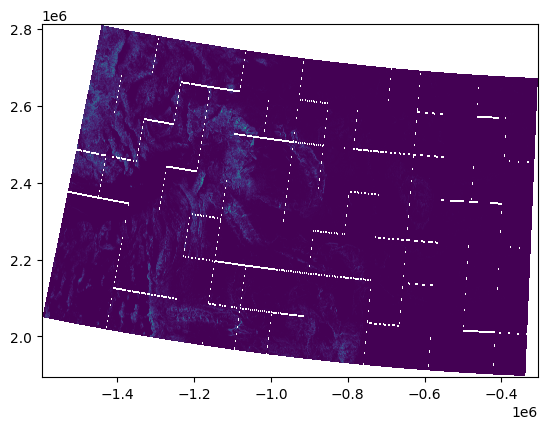

In [19]:
#STitches raster together from the master url

import rasterio
import requests
from io import BytesIO
from rasterio.merge import merge

def download_tiff_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Check if the request was successful
    return BytesIO(response.content)

# URLs of the input rasters
urls = master_url_list

# Download the raster data from the URLs and store them in a list
raster_data_list = [download_tiff_from_url(url) for url in urls]

import rasterio
from rasterio.plot import show

def create_mosaic(raster_data_list, output_path):
    # Open each raster and get its metadata and bounds
    sources = [rasterio.open(r) for r in raster_data_list]

    # Merge the rasters
    mosaic, out_transform = merge(sources)

    # Update the metadata for the mosaic
    out_meta = sources[0].meta.copy()
    out_meta.update({
        'driver': 'GTiff',
        'height': mosaic.shape[1],
        'width': mosaic.shape[2],
        'transform': out_transform
    })

    with rasterio.open(output_path, 'w', **out_meta) as dest:
        dest.write(mosaic)

# Output file path for the mosaic
output_file = r'C:\Users\cowboy\Documents\DEM_Metrics\TRI_1530m_mosaic.tif'

# Call the function to create the mosaic
create_mosaic(raster_data_list, output_file)

with rasterio.open(output_file) as mosaic_ds:
    show(mosaic_ds)

In [79]:
#Saves all raster urls from the api response to the computer

import os
import rasterio
import requests
from io import BytesIO

def download_tiff_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Check if the request was successful
    return BytesIO(response.content)

# URLs of the input rasters
urls = url_list  # Replace `url_list` with your list of .tif URLs

# Download the raster data from the URLs and store them in a list
raster_data_list = [download_tiff_from_url(url) for url in urls]

# Function to save raster data to .tif file
def save_tif_file(raster_data, output_path):
    with open(output_path, 'wb') as f:
        f.write(raster_data.read())

# Folder path to save the raster files
output_folder = r'C:\Users\cowboy\Desktop\rasters\110_109'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Download and save each raster data as a .tif file
for idx, raster_data in enumerate(raster_data_list):
    output_path = os.path.join(output_folder, f'raster_{idx+1}.tif')
    save_tif_file(raster_data, output_path)

print("All raster files downloaded as .tif to C:\\Users\\cowboy\\Desktop\\rasters\\")


All raster files downloaded as .tif to C:\Users\cowboy\Desktop\rasters\
